Load data

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.shape

(72706, 4)

The column 'sentence #' displays the sentence number once and then prints NaN till the next sentence begins.

**Extract mappings required for the neural network**

To train a neural network, we will use two mappings as given below. The neural network will only take integers as input.
- {token} to {token id}: address the row in embeddings matrix for the current token.
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [ ]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,8817,7
1,NaN,of,IN,O,747,7
2,NaN,demonstrators,NNS,O,7054,7
3,NaN,have,VBP,O,8483,7
4,NaN,marched,VBN,O,4125,7


**Transform columns to extract sequential data**


In [ ]:
data.isna().any()

,0
Sentence #,True
Word,False
POS,False
Tag,False
Word_idx,False
Tag_idx,False


In [ ]:
data_fillna = data.fillna(method='ffill', axis=0)
#data_group = data_fillna.groupby(['Sentence #'],as_index=False
                              #  )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group = data_fillna.groupby(['Sentence #'],as_index=False)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))
data_group.head()

<ipython-input-8-4d5c99956208>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[8817, 747, 7054, 8483, 4125, 6481, 7928, 3290...","[7, 7, 7, 7, 7, 7, 12, 7, 7, 7, 7, 7, 12, 7, 7..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[1177, 1917, 6179, 9164, 2502, 3290, 7480, 911...","[8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[5491, 2961, 2804, 4146, 5478, 8083, 4938, 848...","[7, 7, 3, 7, 7, 7, 7, 7, 12, 7, 7, 7, 7, 7, 9,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[3659, 1639, 2645, 3156, 4591, 4647, 8432, 241...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]"
4,Sentence: 1001,"[The, global, financial, crisis, has, left, Ic...","[DT, JJ, JJ, NN, VBZ, VBN, NNP, POS, NN, IN, N...","[O, O, O, O, O, O, B-org, O, O, O, O, O]","[1697, 7216, 9181, 3520, 2137, 1639, 1432, 110...","[7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7]"


**Pad sequences and split the dataset into train, test**

Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])

    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]


    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )

    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 2970 
test_tokens length: 330 
train_tags: 2970 
test_tags: 330


In [ ]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

5209	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
3575	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
3960	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
7751	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7586	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4078	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
6926	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8481	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6040	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1357	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6506	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1036	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6398	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8112	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8481	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2047	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3115	[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
31	[0. 0. 0. 0

**Build Model Layout**


We are building a simple model with 4 layers.

- **Layer 1 - Embedding layer** : We will feed the padded sequences of equal length (104) to the embedding layer. Once the network has been trained, each token will get transformed into a vector of n dimensions. We have chosen the n dimensions to be (64).


- **Layer 2 - Bidirectional LSTM** : Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer (104, 64). The default mode is to concatenate, where the outputs are concatenated together, providing double the number of outputs to the next layer, in our case its 128(64 * 2).

- **Layer 3 - LSTM Layer** : An LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate.

- **Layer 4 - TimeDistributed  Layer** : We are dealing with Many to Many RNN Architecture where we expect output from every input sequence. The TimeDistributeDense layers allow you to apply Dense(fully-connected) operation across every output over every time-step. If you don't use this, you would only have one final output.



This layer take the output dimension of the previous lstm layer (104, 256) and outputs the max sequence length (104) and max tags (17).

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# import keras as k

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  9217 
output_dim:  32 
input_length:  70 
n_tags:  17


In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # Build the model by specifying the input shape
    model.build((None, input_length)) # Add this line

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

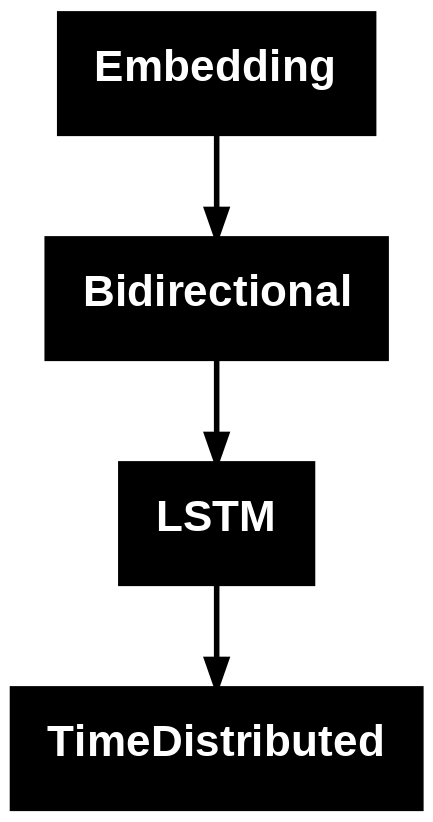

In [ ]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [ ]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3067 - loss: 5.1727 - val_accuracy: 0.9524 - val_loss: 1.2013
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8664 - loss: 1.4578 - val_accuracy: 0.9524 - val_loss: 1.0097
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9293 - loss: 1.2672 - val_accuracy: 0.9524 - val_loss: 0.8445
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9430 - loss: 1.1053 - val_accuracy: 0.9524 - val_loss: 0.7092
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 941ms/step - accuracy: 0.9497 - loss: 0.9708 - val_accuracy: 0.9524 - val_loss: 0.6478
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9522 - loss: 0.8619 - val_accuracy: 0.9524 - val_loss: 0.6217
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 937ms/step - accuracy: 0.9530 - loss: 0.7769 - val_accuracy: 0.9524 - val_loss: 0.6272
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 860ms/step - accuracy: 0.9528 - loss: 0.7125 - val_accuracy: 0.9524 - val_loss: 0.6298
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9532 - loss: 0.6737 - val_accuracy: 0.9524 -

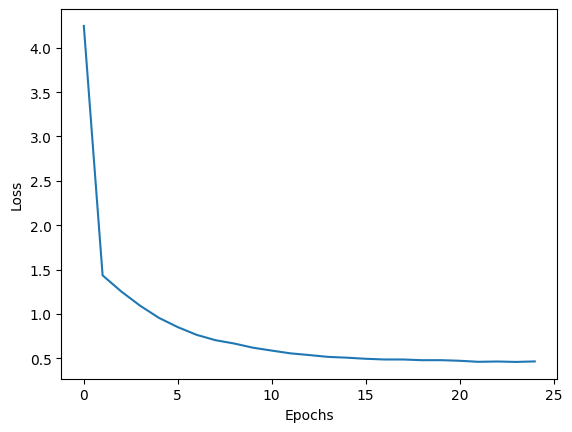

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

## spaCy entities

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [ ]:
for w in text.ents:
    print(w.text, w.label_)

Jim PERSON
300 CARDINAL
Acme Corp. ORG
2006 DATE
300 CARDINAL
one CARDINAL
two CARDINAL
NER ORG
English LANGUAGE
MUC-7 ORG
93.39% PERCENT
97.60% PERCENT
96.95%.[1][2 WORK_OF_ART


In [ ]:
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'

TEST

In [ ]:
s = nlp ('The Eiffel Tower is located in Paris, France.')

displacy.render(s, style = 'ent', jupyter=True)

In [ ]:
spacy.explain('FAC')

'Buildings, airports, highways, bridges, etc.'

In [ ]:
import spacy

# Load your trained model (replace with your model path if needed)
nlp = spacy.load("en_core_web_sm")  # If using a pre-trained model

# Save the model
nlp.to_disk("ner_model")


In [ ]:
from google.colab import files
!zip -r ner_model.zip ner_model
files.download("ner_model.zip")


updating: ner_model/ (stored 0%)
updating: ner_model/attribute_ruler/ (stored 0%)
updating: ner_model/attribute_ruler/patterns (deflated 83%)
updating: ner_model/senter/ (stored 0%)
updating: ner_model/senter/model (deflated 9%)
updating: ner_model/senter/cfg (stored 0%)
updating: ner_model/lemmatizer/ (stored 0%)
updating: ner_model/lemmatizer/lookups/ (stored 0%)
updating: ner_model/lemmatizer/lookups/lookups.bin (deflated 56%)
updating: ner_model/config.cfg (deflated 73%)
updating: ner_model/tok2vec/ (stored 0%)
updating: ner_model/tok2vec/model (deflated 7%)
updating: ner_model/tok2vec/cfg (stored 0%)
updating: ner_model/ner/ (stored 0%)
updating: ner_model/ner/model (deflated 7%)
updating: ner_model/ner/cfg (deflated 33%)
updating: ner_model/ner/moves (deflated 76%)
updating: ner_model/vocab/ (stored 0%)
updating: ner_model/vocab/key2row (stored 0%)
updating: ner_model/vocab/lookups.bin (deflated 43%)
updating: ner_model/vocab/strings.json (deflated 75%)
updating: ner_model/vocab/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import spacy
import joblib

# Load the trained model
nlp = spacy.load("en_core_web_sm")  # Replace with your trained model if needed

# Save the model as a .model file
joblib.dump(nlp, "ner_model.model")


['ner_model.model']